# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation
from scipy.stats import skew
import seaborn as sns
from scipy.stats import mannwhitneyu

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 5
thresholds = np.round(np.arange(0.6,1.00001,0.05), 2)
penalty = 'l1'

displayAll = True

## Create output and copy code

In [2]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))
    os.mkdir(os.path.join(outputFolder, 'figures'))
    
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation_andOutcome.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation_andOutcome.ipynb'))

    file1 = os.path.join(os.path.abspath(""), 'fit_LR_groupSelection_correlationThresholds.py')
    shutil.copyfile(file1, os.path.join(outputFolder, 'code', 'fit_LR_groupSelection_correlationThresholds.py'))

    user = os.path.expanduser("~")
    file2 = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file2, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

### Utility functions

In [3]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [4]:
# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', header = 2, skiprows=[3], nrows=170, engine='openpyxl')
dfClinical.sort_values('Anon Code', inplace=True, ignore_index=True)

# simplify grade
dfClinical['Grade_1_234'] = dfClinical['Grade']==1
dfClinical['Grade_12_34'] = dfClinical['Grade']<=2

# binarised outcome data
cutoffYears = 1.5
cutoffDays = cutoffYears*365

# There is an error in some of the rfs data in the spreadsheet, so re-compute it here.
# rfs = recurrence-free survival.  rfs = 1 if either arfs=1 (local recurrence) or dmfs=1 (distant recurrence)
# and t_rfs is the min of t_arfs and t_dmfs
dfClinical.drop(['rfs', 't_rfs'], inplace=True, axis=1)
dfClinical['rfs'] = np.logical_or(dfClinical['arfs']==1, dfClinical['dmfs']==1).astype(int)
dfClinical['t_rfs'] = dfClinical[['t_arfs', 't_dmfs']].min(axis=1)

def binarizeOutcome(df, new_val1, new_val2, old_val2, feat_time, feat_event, new_feat_name):

    df[new_feat_name] = new_val1
    df.loc[df[feat_time] >= cutoffDays, new_feat_name] = new_val2
    df.loc[np.logical_and(df[feat_time] < cutoffDays, df[feat_event] == old_val2), new_feat_name] = 'Unknown'

binarizeOutcome(dfClinical, 'Dead', 'Alive', 'Alive', 't_os', 'os', 'os_cutoff')
binarizeOutcome(dfClinical, 'Yes', 'No', 0, 't_dmfs', 'dmfs', 'distant_cutoff')
binarizeOutcome(dfClinical, 'Yes', 'No', 0, 't_arfs', 'arfs', 'local_cutoff')
binarizeOutcome(dfClinical, 'Yes', 'No', 0, 't_rfs', 'rfs', 'recurrence_cutoff')

dfClinical = dfClinical[['Anon Code', 
                         'Grade_1_234', 
                         'Grade_12_34', 
                         'subtype', 
                         'os_cutoff', 
                         'distant_cutoff',
                         'local_cutoff',
                         'recurrence_cutoff']]


# TEST open clinical spreadsheet
clinicalSpreadsheetTest = os.path.join(rootFolder, 'ClinicalData', 'EORTC_Radsarc_Clindata.xlsx')
dfClinicalTest = pd.read_excel(clinicalSpreadsheetTest, sheet_name='Completed segs_for analysis', engine='openpyxl')
dfClinicalTest['Anon Code'] = ['EORTCRSRC_' + str(int(x)).zfill(3) for x in dfClinicalTest['PATID']]

# simplify grade
dfClinicalTest['Grade_1_234'] = dfClinicalTest['grade']==1
dfClinicalTest['Grade_12_34'] = dfClinicalTest['grade']<=2

# make rfs data

dfClinicalTest['rfs'] = np.logical_or(dfClinicalTest['arfs2']==1, dfClinicalTest['dmfs']==1).astype(int)
dfClinicalTest['t_rfs'] = dfClinicalTest[['t_arfs2', 't_dmfs']].min(axis=1)

# binarised outcome data
binarizeOutcome(dfClinicalTest, 'Dead', 'Alive', 1, 't_ss', 'ss', 'os_cutoff')
binarizeOutcome(dfClinicalTest, 'Yes', 'No', 1, 't_dmfs', 'dmfs', 'distant_cutoff')
binarizeOutcome(dfClinicalTest, 'Yes', 'No', 1, 't_arfs2', 'arfs2', 'local_cutoff')
binarizeOutcome(dfClinicalTest, 'Yes', 'No', 1, 't_rfs', 'rfs', 'recurrence_cutoff')

dfClinicalTest = dfClinicalTest[['Anon Code', 
                                 'Grade_1_234', 
                                 'Grade_12_34', 
                                 'subtype',
                                 'os_cutoff', 
                                 'distant_cutoff',
                                 'local_cutoff',
                                 'recurrence_cutoff']]


In [5]:
def readRadData(folder):
    df = pd.read_csv(os.path.join(rootFolder, 'XNAT', 'extractions', folder, 'radiomicFeatures', 'radiomicFeatures.csv'))
    df.drop(list(df.filter(regex = 'source')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'diagnostic')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'histogram')), axis = 1, inplace = True)
    return df

# training
dfRad = readRadData('extractions__20221122_1628_allRegions_volFracApprox')

# reproducibility
dfRadRep = readRadData('extractions__20221122_2037_repro_volFracApprox')

# open test data
dfRadTest = readRadData('extractions__20221125_0939_eortcTestData')

## Compute ICCs and remove unreproducible features

In [6]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)
dfRadTest = dfRadTest.filter(reproducibleFeatures)

## Log transform positive skewed parameters

In [7]:
def makeLog(df, feat, offset=0):
    df[feat+'_log'] = np.log(df[feat]+offset)
    df.drop(feat, axis=1, inplace=True)
    return df

for feat in dfRad.filter(regex='lesion_original', axis=1).columns:
    if skew(dfRad[feat])>3 and np.all(dfRad[feat]>0):
        dfRad = makeLog(dfRad, feat)
        dfRadTest = makeLog(dfRadTest, feat)

# this is heavily skewed, but has minimum value -87
dfRad = makeLog(dfRad, 'lesion_original_glcm_ClusterShade', offset=90)
dfRadTest = makeLog(dfRadTest, 'lesion_original_glcm_ClusterShade', offset=90)

In [8]:
def featureClassDensities(df_Train, df_Test, featureClass, spSize):
    f,a = plt.subplots(spSize[0], spSize[1], figsize=(20,12))
    a = a.ravel()
    for n, feat in enumerate(df_Train.filter(regex = featureClass, axis = 1).columns):
        df1 = pd.DataFrame(df_Train[feat].copy())
        df1['Data'] = 'train'
        df2 = pd.DataFrame(df_Test[feat].copy())
        df2['Data'] = 'test'
        dfPlot = pd.concat([df1, df2])
        dfPlot.reset_index(drop=True, inplace=True)
        featPlot = feat.replace('lesion_original_' + featureClass + '_','')
        dfPlot.rename(columns={feat:featPlot}, inplace=True)
        sns.kdeplot(data=dfPlot, x=featPlot, hue='Data', ax = a[n], common_grid=True, common_norm=False)

if False:
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'shape', (3, 5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'firstorder', (3,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glcm', (4,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glrlm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glszm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'gldm', (3,5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'ngtdm', (2,3))


## Select targets

In [9]:
# targets = ['subtype', 'Grade_1_234', 'Grade_12_34']
targets = ['os_cutoff', 'distant_cutoff', 'local_cutoff', 'recurrence_cutoff']

## Run classifications

In [10]:
def prepData(dfC, dfR, target, featureSet, removeTargetUnknown=True):
    df = dfC.merge(dfR, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)
    df = df.filter(regex=featureSet + '|' + target)
    if removeTargetUnknown:
        df = df.loc[df[target] != 'Unknown',:]
    return df

def fitModelOrLoadSaved(df, target, settings, qlf):
    
    if os.path.exists(qlf):
        with open(qlf, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(qlf, 'wb') as handle:
                pickle.dump(result, handle)

    return copy.deepcopy(result)

def showTrainTestResults(result):
    
    # find best model i.e. across all thresholds
    AUROC_cv = np.array([np.mean(x['cv_result']['test_score']) for x in result['experiments']])
    idx = np.argmax(AUROC_cv)
    bestExperiment = result['experiments'][idx]

    trainScore = bestExperiment['model'].predict_proba(df.drop(target, axis=1))
    testScore = bestExperiment['model'].predict_proba(dfTest.drop(target, axis=1))
    
    aucTest = roc_auc_score(dfTest[target], testScore[:,1])
    classLabels = list(set(dfTest[target]))
 
    if aucTest>0.6:
        # get p-value on test data
        testScores0 = testScore[dfTest[target]==classLabels[0],1]
        testScores1 = testScore[dfTest[target]==classLabels[1],1]
        _, pValue = mannwhitneyu(testScores0, testScores1, alternative='two-sided')
        pValueStr = str(pValue)
    else:
        pValueStr = 'not computed'
        
    print('AUC')
    print('train #      = ' + str(np.sum(df[target]==classLabels[0])) + ' : ' + str(np.sum(df[target]==classLabels[1])))
    print('train resub  = ' + str(np.round(roc_auc_score(df[target], trainScore[:,1]),3)))
    print('train CV     = ' + str(np.round(np.mean(bestExperiment['cv_result']['test_score']),3)))
    print('\n')
    print('test #       = ' + str(np.sum(dfTest[target]==classLabels[0])) + ' : ' + str(np.sum(dfTest[target]==classLabels[1])))
    print('test         = ' + str(np.round(aucTest,3)))
    print('test p-value = ' + pValueStr)
    print('\n')

defaultSettings = {'n_splits':n_splits, 
                   'n_repeats':n_repeats,
                   'thresholds':thresholds,
                   'penalty':penalty
                   }

### Standard radiomics features

os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_

Threshold = 0.6
shape
AUROC = 0.543 ± 0.1968

Threshold = 0.65
firstorder
AUROC = 0.589 ± 0.1833

Threshold = 0.7
firstorder
AUROC = 0.657 ± 0.1501

Threshold = 0.75
firstorder
AUROC = 0.626 ± 0.1583

Threshold = 0.8
firstorder
AUROC = 0.623 ± 0.1557

Threshold = 0.85
firstorder
AUROC = 0.622 ± 0.1554

Threshold = 0.9
firstorder
AUROC = 0.618 ± 0.1547

Threshold = 0.95
firstorder
AUROC = 0.563 ± 0.1705

Threshold = 1.0
shape|firstorder
AUROC = 0.621 ± 0.1615



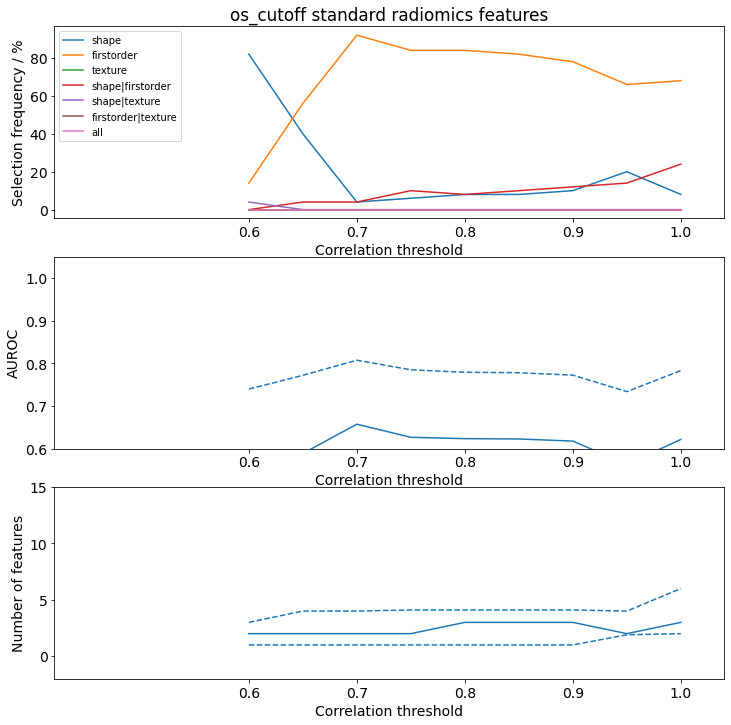

Threshold = 0.7
AUROC (CV) = 0.65718

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,58.000,0.806
lesion_original_firstorder_InterquartileRange,44.000,-0.058



os_cutoff
AUC
train #      = 23 : 125
train resub  = 0.706
train CV     = 0.657


test #       = 5 : 82
test         = 0.578
test p-value = not computed


distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_

Threshold = 0.6
shape
AUROC = 0.587 ± 0.1648

Threshold = 0.65
shape|firstorder
AUROC = 0.696 ± 0.1561

Threshold = 0.7
shape|firstorder
AUROC = 0.751 ± 0.1322

Threshold = 0.75
shape|firstorder
AUROC = 0.747 ± 0.1288

Threshold = 0.8
shape|firstorder
AUROC = 0.745 ± 0.1246

Threshold = 0.85
shape|firstorder
AUROC = 0.744 ± 0.1252

Threshold = 0.9
shape|firstorder
AUROC = 0.747 ± 0.1191

Threshold = 0.95
shape|firstorder
AUROC = 0.767 ± 0.1207

Threshold = 1.0
shape|firstorder
AUROC = 0.755 ± 0.1228



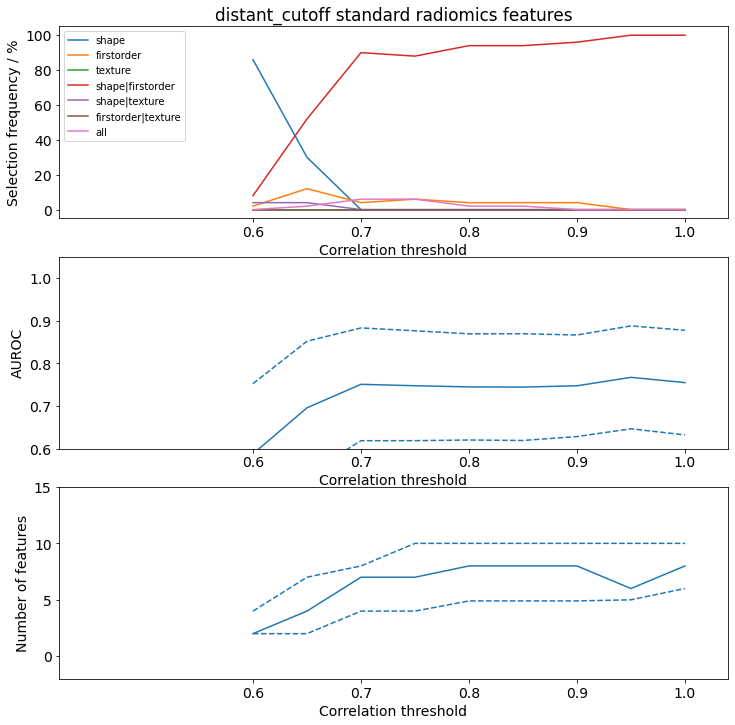

Threshold = 0.95
AUROC (CV) = 0.76707

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,-0.742
lesion_original_firstorder_Median,100.000,1.162
lesion_original_shape_Flatness,90.000,0.203
lesion_original_firstorder_90Percentile,88.000,0.153
lesion_original_shape_Elongation,84.000,0.104
lesion_original_firstorder_Kurtosis_log,66.000,-0.031



distant_cutoff
AUC
train #      = 31 : 111
train resub  = 0.816
train CV     = 0.767


test #       = 12 : 75
test         = 0.562
test p-value = not computed


local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_

Threshold = 0.6
shape
AUROC = 0.412 ± 0.153

Threshold = 0.65
shape
AUROC = 0.449 ± 0.1433

Threshold = 0.7
firstorder
AUROC = 0.467 ± 0.1489

Threshold = 0.75
firstorder
AUROC = 0.465 ± 0.1573

Threshold = 0.8
shape
AUROC = 0.459 ± 0.1674

Threshold = 0.85
shape
AUROC = 0.459 ± 0.1674

Threshold = 0.9
shape
AUROC = 0.473 ± 0.0956

Threshold = 0.95
shape
AUROC = 0.47 ± 0.0967

Threshold = 1.0
firstorder
AUROC = 0.477 ± 0.1955



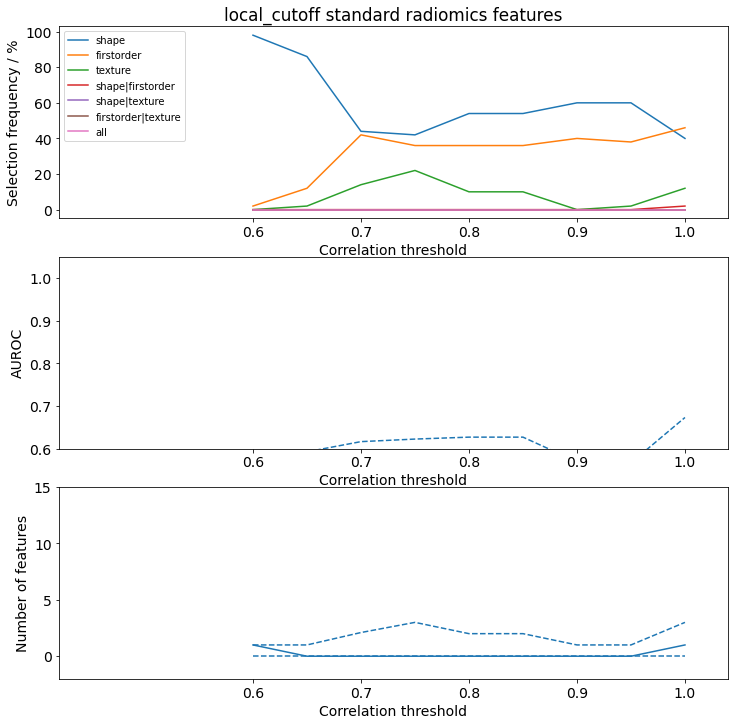

Threshold = 1.0
AUROC (CV) = 0.47742

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_Variance_log,30.000,-0.082



local_cutoff
AUC
train #      = 15 : 115
train resub  = 0.631
train CV     = 0.477


test #       = 12 : 75
test         = 0.45
test p-value = not computed


recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_

Threshold = 0.6
shape
AUROC = 0.564 ± 0.1558

Threshold = 0.65
shape|firstorder
AUROC = 0.594 ± 0.1511

Threshold = 0.7
shape|firstorder
AUROC = 0.658 ± 0.1272

Threshold = 0.75
shape|firstorder
AUROC = 0.664 ± 0.1394

Threshold = 0.8
shape|firstorder
AUROC = 0.663 ± 0.1397

Threshold = 0.85
shape|firstorder
AUROC = 0.663 ± 0.1397

Threshold = 0.9
shape|firstorder
AUROC = 0.666 ± 0.1411

Threshold = 0.95
shape|firstorder
AUROC = 0.69 ± 0.1363

Threshold = 1.0
shape|firstorder
AUROC = 0.714 ± 0.144



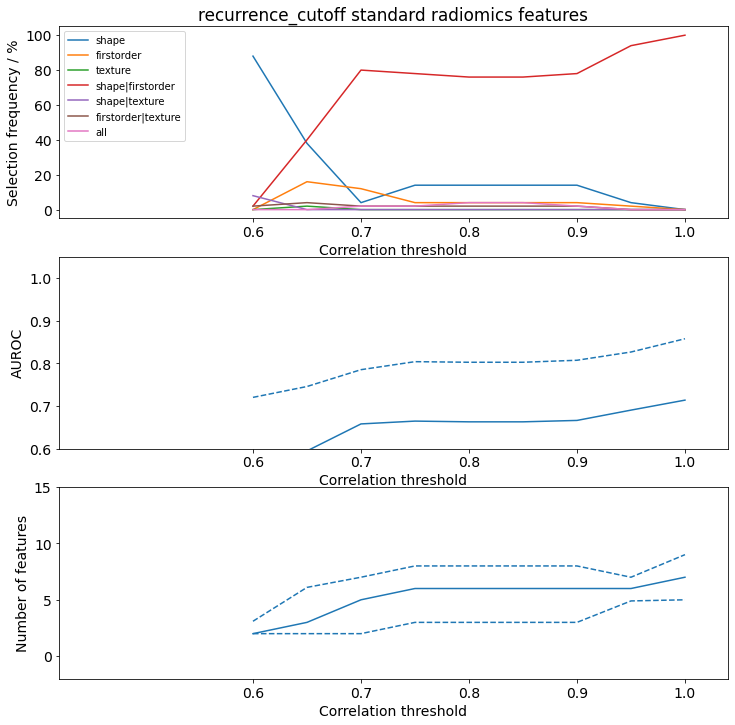

Threshold = 1.0
AUROC (CV) = 0.71361

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,-0.959
lesion_original_firstorder_10Percentile,100.000,0.943
lesion_original_shape_Flatness,94.000,0.335
lesion_original_firstorder_Skewness,82.000,-0.127
lesion_original_firstorder_Mean,62.000,0.186
lesion_original_firstorder_Kurtosis_log,34.000,-0.022



recurrence_cutoff
AUC
train #      = 42 : 103
train resub  = 0.789
train CV     = 0.714


test #       = 10 : 69
test         = 0.677
test p-value = 0.0732259591558738




In [11]:
if True:

    resultStandard = {}
    
    for target in targets:
        
        print((target + '_')*10 + '\n')
        
        featureSet = 'lesion_original'

        df = prepData(dfClinical, dfRad, target, featureSet)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet)
        
        settings = defaultSettings.copy()
        textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
        settings['groupHierarchy'] = ['shape',
                                      'firstorder',
                                      textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']

        quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_' + target + '.pickle')

        resultStandard[target] = fitModelOrLoadSaved(df, target, settings, quickLoadFile)

        if displayAll:
            plotResultExperiments(resultStandard[target], 
                                  titleStr=target + ' standard radiomics features',
                                  outputFile=os.path.join(outputFolder, 'figures', target + '_standard.pdf'))

            bestCoef, pdFreq = displayOneExperiment(resultStandard[target])
            pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
            display(pdFreq.style.hide_index())

        print('\n'+target)
        showTrainTestResults(resultStandard[target])

### Volume fraction and standard radiomics features

os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_

Threshold = 0.6
VolumeFraction
AUROC = 0.598 ± 0.1748

Threshold = 0.65
VolumeFraction
AUROC = 0.603 ± 0.1762

Threshold = 0.7
VolumeFraction
AUROC = 0.601 ± 0.1746

Threshold = 0.75
firstorder
AUROC = 0.568 ± 0.1865

Threshold = 0.8
firstorder
AUROC = 0.571 ± 0.1783

Threshold = 0.85
firstorder
AUROC = 0.575 ± 0.1875

Threshold = 0.9
firstorder
AUROC = 0.577 ± 0.1883

Threshold = 0.95
VolumeFraction
AUROC = 0.567 ± 0.1835

Threshold = 1.0
VolumeFraction
AUROC = 0.572 ± 0.1603



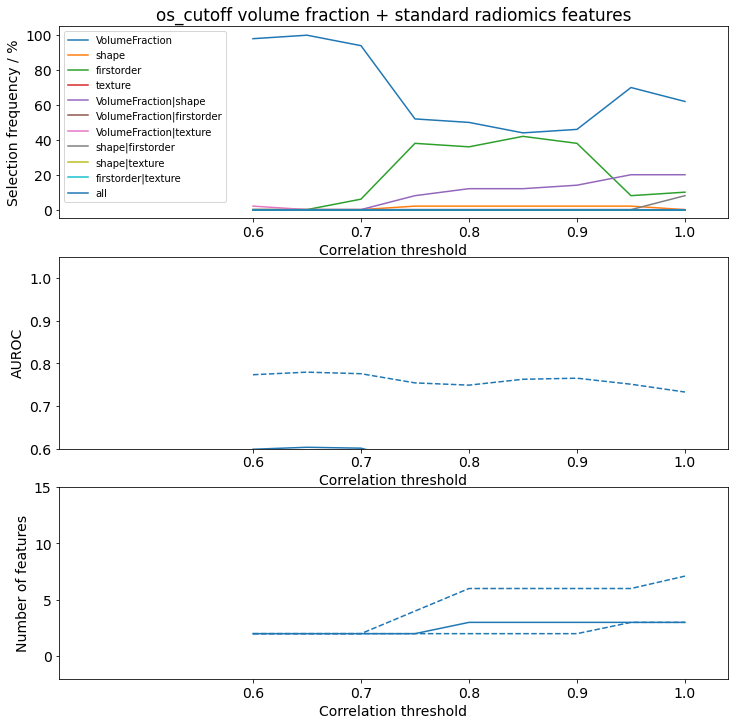

Threshold = 0.65
AUROC (CV) = 0.60302

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_calcificationVolumeFraction,100.000,0.083
lesion_sarcomaFeature_high enhancingVolumeFraction,98.000,0.580



os_cutoff
AUC
train #      = 23 : 125
train resub  = 0.647
train CV     = 0.603


test #       = 5 : 82
test         = 0.546
test p-value = not computed


distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_

Threshold = 0.6
VolumeFraction
AUROC = 0.602 ± 0.1535

Threshold = 0.65
VolumeFraction
AUROC = 0.598 ± 0.1454

Threshold = 0.7
VolumeFraction
AUROC = 0.603 ± 0.1474

Threshold = 0.75
shape|firstorder
AUROC = 0.696 ± 0.1525

Threshold = 0.8
shape|firstorder
AUROC = 0.716 ± 0.1434

Threshold = 0.85
shape|firstorder
AUROC = 0.742 ± 0.1393

Threshold = 0.9
shape|firstorder
AUROC = 0.743 ± 0.1384

Threshold = 0.95
shape|firstorder
AUROC = 0.746 ± 0.1231

Threshold = 1.0
shape|firstorder
AUROC = 0.746 ± 0.1485



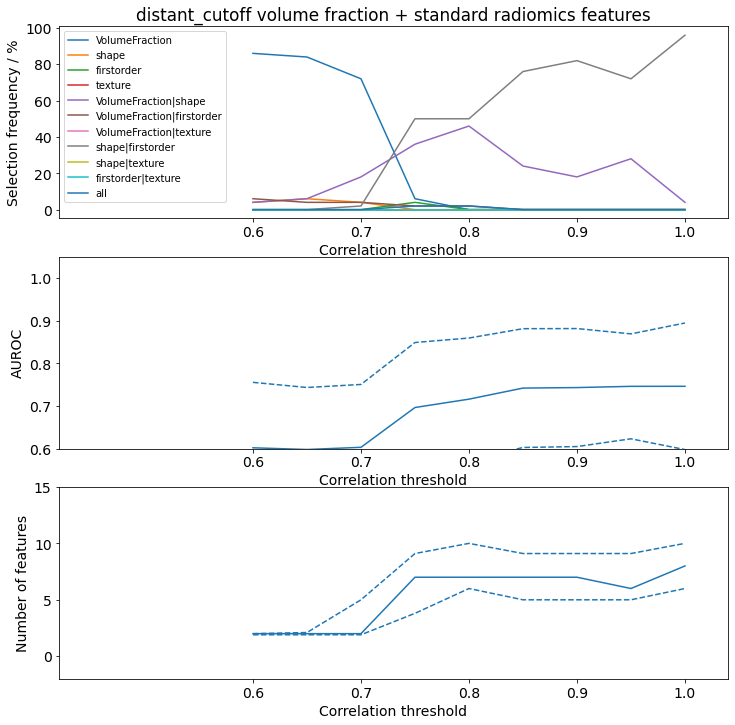

Threshold = 1.0
AUROC (CV) = 0.74606

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,-0.779
lesion_original_shape_Flatness,92.000,0.180
lesion_original_firstorder_Mean,84.000,1.002
lesion_original_firstorder_Kurtosis_log,84.000,-0.145
lesion_original_shape_Elongation,82.000,0.126
lesion_original_firstorder_10Percentile,82.000,0.294
lesion_original_firstorder_Median,50.000,0.083
lesion_original_firstorder_Range,50.000,0.091
lesion_original_shape_Maximum2DDiameterSlice,40.000,0.002



distant_cutoff
AUC
train #      = 31 : 111
train resub  = 0.823
train CV     = 0.746


test #       = 12 : 75
test         = 0.559
test p-value = not computed


local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_

Threshold = 0.6
VolumeFraction
AUROC = 0.526 ± 0.2618

Threshold = 0.65
VolumeFraction
AUROC = 0.518 ± 0.2688

Threshold = 0.7
VolumeFraction
AUROC = 0.533 ± 0.2587

Threshold = 0.75
VolumeFraction
AUROC = 0.541 ± 0.269

Threshold = 0.8
VolumeFraction
AUROC = 0.506 ± 0.2608

Threshold = 0.85
VolumeFraction
AUROC = 0.516 ± 0.2506

Threshold = 0.9
VolumeFraction
AUROC = 0.54 ± 0.2381

Threshold = 0.95
VolumeFraction
AUROC = 0.554 ± 0.24

Threshold = 1.0
VolumeFraction
AUROC = 0.548 ± 0.273



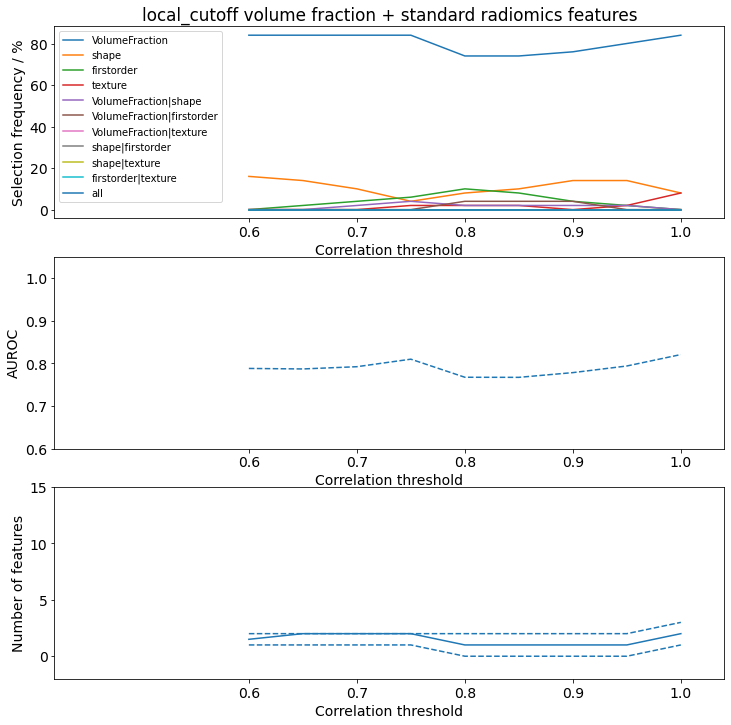

Threshold = 0.95
AUROC (CV) = 0.55371

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,82.000,0.404
lesion_sarcomaFeature_calcificationVolumeFraction,36.000,-0.016



local_cutoff
AUC
train #      = 15 : 115
train resub  = 0.616
train CV     = 0.554


test #       = 12 : 75
test         = 0.534
test p-value = not computed


recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_

Threshold = 0.6
VolumeFraction
AUROC = 0.634 ± 0.134

Threshold = 0.65
VolumeFraction
AUROC = 0.635 ± 0.135

Threshold = 0.7
VolumeFraction|shape
AUROC = 0.645 ± 0.1264

Threshold = 0.75
shape|firstorder
AUROC = 0.67 ± 0.1477

Threshold = 0.8
VolumeFraction|shape
AUROC = 0.698 ± 0.1466

Threshold = 0.85
VolumeFraction|shape
AUROC = 0.693 ± 0.1466

Threshold = 0.9
VolumeFraction|shape
AUROC = 0.693 ± 0.1466

Threshold = 0.95
VolumeFraction|shape
AUROC = 0.694 ± 0.1472

Threshold = 1.0
shape|firstorder
AUROC = 0.692 ± 0.1617



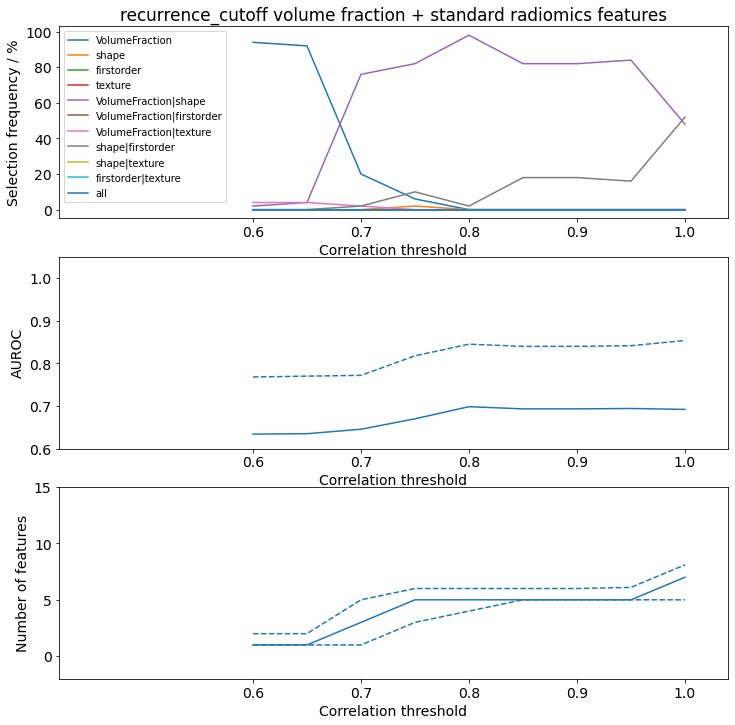

Threshold = 0.8
AUROC (CV) = 0.69825

Feature group = VolumeFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Flatness,100.000,0.325
lesion_original_shape_Sphericity,100.000,-0.798
lesion_sarcomaFeature_low enhancingVolumeFraction,98.000,-0.711
lesion_sarcomaFeature_high enhancingVolumeFraction,98.000,0.406
lesion_original_shape_SurfaceVolumeRatio_log,88.000,0.083



recurrence_cutoff
AUC
train #      = 42 : 103
train resub  = 0.767
train CV     = 0.698


test #       = 10 : 69
test         = 0.641
test p-value = 0.1547898275418646




In [12]:
if True:
    
    resultVolFrac = {}
    
    for target in targets:

        print((target + '_')*10 + '\n')
        
        featureSet = 'lesion_original|VolumeFraction'

        df = prepData(dfClinical, dfRad, target, featureSet)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet)
        
        # remove one of the volume fraction features as it is co-linear with the others
        df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)
        dfTest.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

        settings = defaultSettings.copy()
        textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
        settings['groupHierarchy'] = ['VolumeFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'VolumeFraction|shape',
                                      'VolumeFraction|firstorder',
                                      'VolumeFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
        settings['correlationHierarchy'] = ['VolumeFraction', 'shape', 'firstorder']

        
        quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_' + target + '.pickle')

        resultVolFrac[target] = fitModelOrLoadSaved(df, target, settings, quickLoadFile)

        if displayAll:
            plotResultExperiments(resultVolFrac[target], 
                                  titleStr = target + ' volume fraction + standard radiomics features',
                                  outputFile=os.path.join(outputFolder, 'figures', target+'_standard_volFrac.pdf'))


            bestCoef, pdFreq = displayOneExperiment(resultVolFrac[target])
            pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
            display(pdFreq.style.hide_index())

        print('\n'+target)
        showTrainTestResults(resultVolFrac[target])

### Approx volume fraction and standard radiomics features

os_cutoff_os_cutoff_os_cutoff_os_cutoff_os_cutoff_

Threshold = 0.6
ApproxVolFraction
AUROC = 0.69 ± 0.1718

Threshold = 0.65
ApproxVolFraction|shape
AUROC = 0.683 ± 0.1737

Threshold = 0.7
ApproxVolFraction|shape
AUROC = 0.681 ± 0.1729

Threshold = 0.75
ApproxVolFraction|shape
AUROC = 0.663 ± 0.1617

Threshold = 0.8
ApproxVolFraction|shape
AUROC = 0.666 ± 0.1611

Threshold = 0.85
ApproxVolFraction|shape
AUROC = 0.662 ± 0.1616

Threshold = 0.9
ApproxVolFraction|shape
AUROC = 0.656 ± 0.1687

Threshold = 0.95
ApproxVolFraction|shape
AUROC = 0.653 ± 0.1687

Threshold = 1.0
ApproxVolFraction|shape
AUROC = 0.671 ± 0.1682



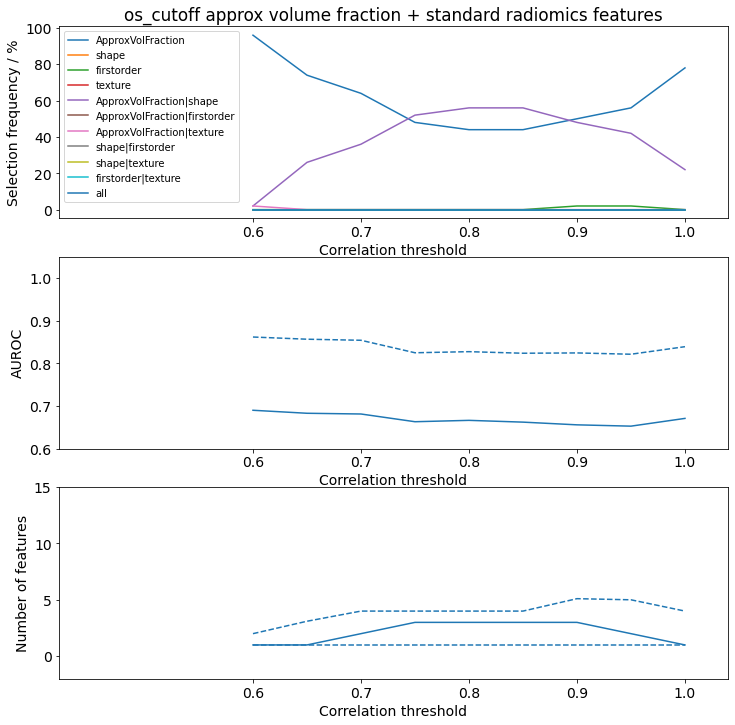

Threshold = 0.6
AUROC (CV) = 0.68983

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,96.000,0.792



os_cutoff
AUC
train #      = 23 : 125
train resub  = 0.712
train CV     = 0.69


test #       = 5 : 82
test         = 0.656
test p-value = 0.24683952723361147


distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_distant_cutoff_

Threshold = 0.6
ApproxVolFraction
AUROC = 0.731 ± 0.1596

Threshold = 0.65
ApproxVolFraction|shape
AUROC = 0.761 ± 0.1311

Threshold = 0.7
ApproxVolFraction|shape
AUROC = 0.757 ± 0.1308

Threshold = 0.75
ApproxVolFraction|shape
AUROC = 0.752 ± 0.1287

Threshold = 0.8
ApproxVolFraction|shape
AUROC = 0.75 ± 0.1265

Threshold = 0.85
ApproxVolFraction|shape
AUROC = 0.75 ± 0.1269

Threshold = 0.9
ApproxVolFraction|shape
AUROC = 0.764 ± 0.1206

Threshold = 0.95
ApproxVolFraction|shape
AUROC = 0.77 ± 0.1202

Threshold = 1.0
ApproxVolFraction|shape
AUROC = 0.754 ± 0.1398



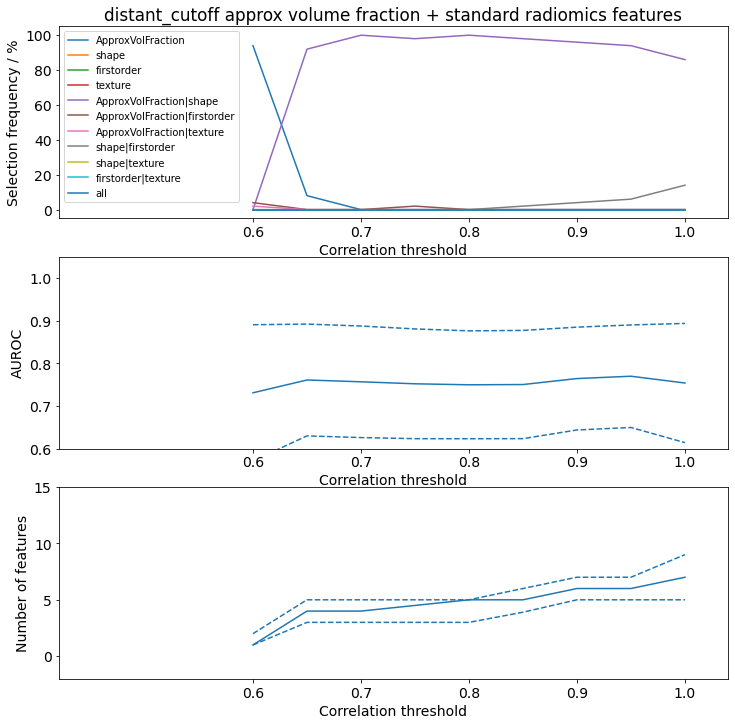

Threshold = 0.95
AUROC (CV) = 0.7697

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,-1.144
lesion_original_shape_Flatness,96.000,0.264
lesion_sarcomaFeature_lowApproxVolFraction,94.000,-0.983
lesion_sarcomaFeature_highApproxVolFraction,94.000,0.915
lesion_original_shape_Elongation,90.000,0.232
lesion_original_shape_LeastAxisLength,36.000,0.026



distant_cutoff
AUC
train #      = 31 : 111
train resub  = 0.818
train CV     = 0.77


test #       = 12 : 75
test         = 0.571
test p-value = not computed


local_cutoff_local_cutoff_local_cutoff_local_cutoff_local_cutoff_

Threshold = 0.6
ApproxVolFraction
AUROC = 0.418 ± 0.1727

Threshold = 0.65
ApproxVolFraction
AUROC = 0.416 ± 0.1688

Threshold = 0.7
ApproxVolFraction
AUROC = 0.509 ± 0.2457

Threshold = 0.75
ApproxVolFraction
AUROC = 0.509 ± 0.2441

Threshold = 0.8
ApproxVolFraction
AUROC = 0.501 ± 0.2514

Threshold = 0.85
ApproxVolFraction
AUROC = 0.499 ± 0.2494

Threshold = 0.9
ApproxVolFraction
AUROC = 0.508 ± 0.2341

Threshold = 0.95
ApproxVolFraction
AUROC = 0.514 ± 0.2243

Threshold = 1.0
ApproxVolFraction
AUROC = 0.509 ± 0.2512



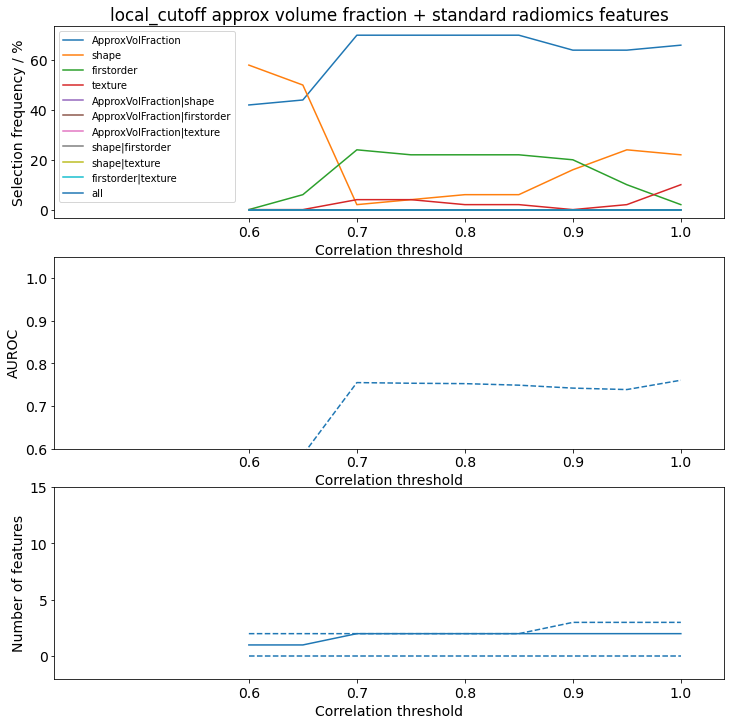

Threshold = 0.95
AUROC (CV) = 0.51409

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,64.000,0.266
lesion_sarcomaFeature_calcApproxVolFraction,48.000,-0.086



local_cutoff
AUC
train #      = 15 : 115
train resub  = 0.57
train CV     = 0.514


test #       = 12 : 75
test         = 0.563
test p-value = not computed


recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_recurrence_cutoff_

Threshold = 0.6
ApproxVolFraction
AUROC = 0.681 ± 0.1496

Threshold = 0.65
ApproxVolFraction|shape
AUROC = 0.695 ± 0.15

Threshold = 0.7
ApproxVolFraction|shape
AUROC = 0.722 ± 0.1456

Threshold = 0.75
ApproxVolFraction|shape
AUROC = 0.734 ± 0.151

Threshold = 0.8
ApproxVolFraction|shape
AUROC = 0.735 ± 0.1501

Threshold = 0.85
ApproxVolFraction|shape
AUROC = 0.733 ± 0.152

Threshold = 0.9
ApproxVolFraction|shape
AUROC = 0.734 ± 0.1551

Threshold = 0.95
ApproxVolFraction|shape
AUROC = 0.737 ± 0.1542

Threshold = 1.0
ApproxVolFraction|shape
AUROC = 0.733 ± 0.1585



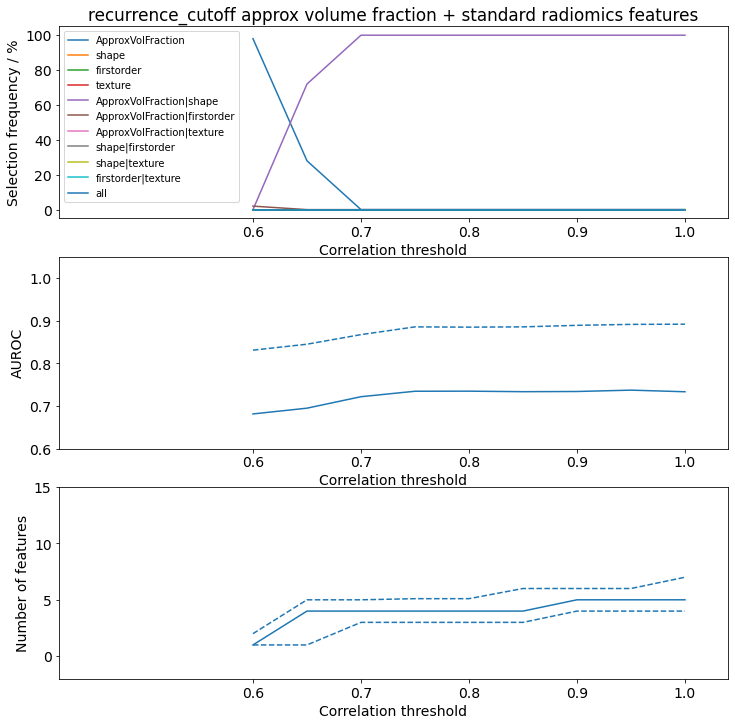

Threshold = 0.95
AUROC (CV) = 0.73705

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Flatness,100.000,0.307
lesion_original_shape_Sphericity,100.000,-0.867
lesion_sarcomaFeature_highApproxVolFraction,100.000,1.032
lesion_sarcomaFeature_lowApproxVolFraction,76.000,-0.126
lesion_sarcomaFeature_calcApproxVolFraction,62.000,-0.021



recurrence_cutoff
AUC
train #      = 42 : 103
train resub  = 0.781
train CV     = 0.737


test #       = 10 : 69
test         = 0.699
test p-value = 0.04415854830541565




In [13]:
if True:
    
    resultApproxVolFrac = {}
    
    for target in targets:

        print((target + '_')*5 + '\n')
        
        featureSet = 'lesion_original|ApproxVolFraction'

        df = prepData(dfClinical, dfRad, target, featureSet)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet)

        settings = defaultSettings.copy()
        textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
        settings['groupHierarchy'] = ['ApproxVolFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'ApproxVolFraction|shape',
                                      'ApproxVolFraction|firstorder',
                                      'ApproxVolFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
        settings['correlationHierarchy'] = ['ApproxVolFraction', 'shape', 'firstorder']
        
        quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_ApproxVolFraction_' + target + '.pickle')

        resultApproxVolFrac[target] = fitModelOrLoadSaved(df, target, settings, quickLoadFile)

        if displayAll:
            plotResultExperiments(resultApproxVolFrac[target], 
                                  titleStr = target + ' approx volume fraction + standard radiomics features',
                                  outputFile=os.path.join(outputFolder, 'figures', target+'_approx_volFrac.pdf'))


            bestCoef, pdFreq = displayOneExperiment(resultApproxVolFrac[target])
            pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
            display(pdFreq.style.hide_index())

        print('\n'+target)
        showTrainTestResults(resultApproxVolFrac[target])

## Re-save the copy of this notebook once it is completed

In [14]:
from IPython.display import display, Javascript
import time

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(10)

# copy notebook to output folder
if saveOutputs:
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation_andOutcome.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation_andOutcome.ipynb'))

<IPython.core.display.Javascript object>